# Experimental/mixed approach
In this notebook, we will be testing a network which will use the data from dataset to train itself.

In [1]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, Subset
import importlib
import torchvision.transforms as transforms
import xai
import numpy as np


seed=42
model_utils.fix_random(seed)
TRAINING_MODE=True
plotter.set_display_mode(True)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL not scrollable bug

c:\Users\tekke\Desktop\gauntlet\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparing the data

As we're using a mixed approach, we would need to upscale the CIFAKE images to match the size of the other, more complicated ones. Obviously, we will apply all the other transformations needed to the RVAA dataset.

As the CIFAKE dataset is much more oversampled than the RVAA dataset (120'000 vs 1'000 samples) we need to take in consideration a very small subset of CIFAKE in order to create a properly balanced mixed dataset. In particular, we take about 1200 samples from CIFAKE.

In [2]:
IMG_SIZE = 224

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize to IMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

d1 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
d2 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)
cifake_dataset = ConcatDataset([d1, d2])

# Selecting a subset of the CIFAKE datasets
portion_size = int(0.008 * len(cifake_dataset))
indices = list(range(portion_size))
cifake_dataset = Subset(cifake_dataset, indices)

transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)

# the final dataset that's going to be used
merged_dataset = ConcatDataset([cifake_dataset, rvaa_dataset])

In [3]:
LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 64
DATASET_NAME = "MIXED"

In [4]:
# WARNING: IF YOU REBUILD THE DATALOADER, THE RESULT WILL DIFFER. RESTART THE KERNEL AND TRAIN AGAIN TO HAVE THE SAME RESULTS.
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=merged_dataset, isRandom=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

print(len(val_dataset), len(test_dataset), len(train_dataset))

289 290 1351


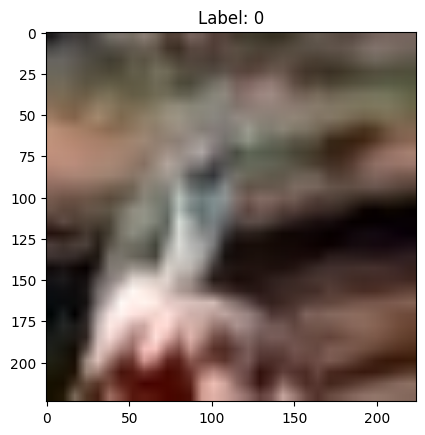

In [5]:
data_utils.show_random_sample(train_dataloader)

## Model
Since the model that has been giving us great results so far is a ResNet50, we can try and use it again to see if it manages to capture the patterns learned from CIFAKE with the patterns learned from RealVsAiArt.

In [6]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
device = model_utils.get_device()
print(f"using {device} device")

model_utils.prepare_for_ft(ft_resnet50)
ft_resnet50.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

using cuda device


## Training setup
The training is done using 20 epochs and a batch size of 64.
As before, we use a 2-step training method which allows us to train the classification head first and then the feature extractor. As shown in the CIFAKE model, this usually deals pretty good results.

In [7]:
model_name = "MixResNet"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 78.9%, Avg loss: 0.475052
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 78.2%, Avg loss: 0.416072
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 80.3%, Avg loss: 0.388655
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 79.6%, Avg loss: 0.379914
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 80.6%, Avg loss: 0.370956
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 75.8%, Avg loss: 0.388762


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 80.3%, Avg loss: 0.362627
New best model

In [8]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 85.5%, Avg loss: 0.296692
Confusion matrix report, tp: 193, fp: 13, fn: 29, tn:55
Precision: 0.94, Recall: 0.87, F1-Score: 0.90


(0.2966919541358948, tensor(0.8552, device='cuda:0'))

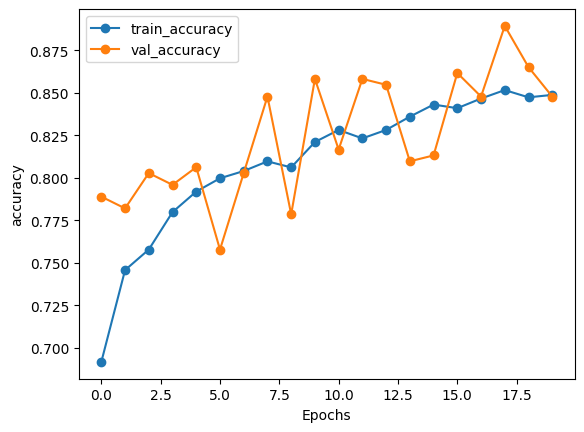

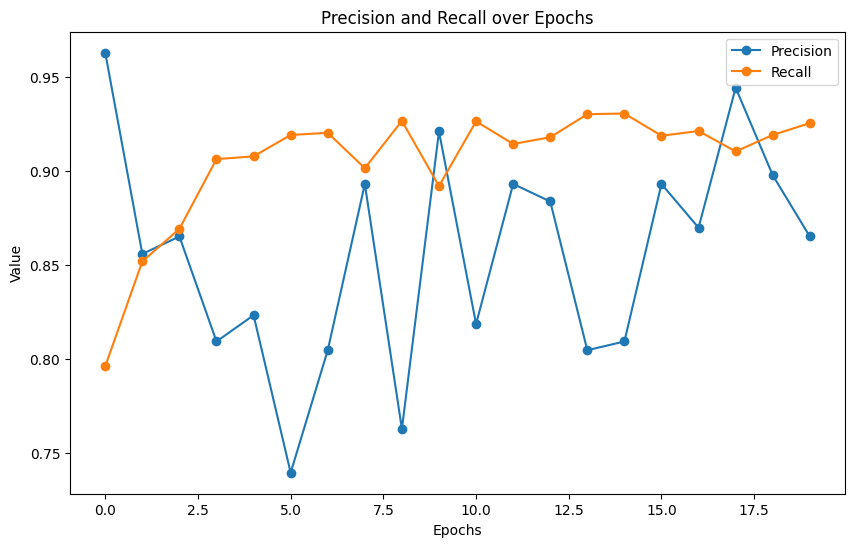

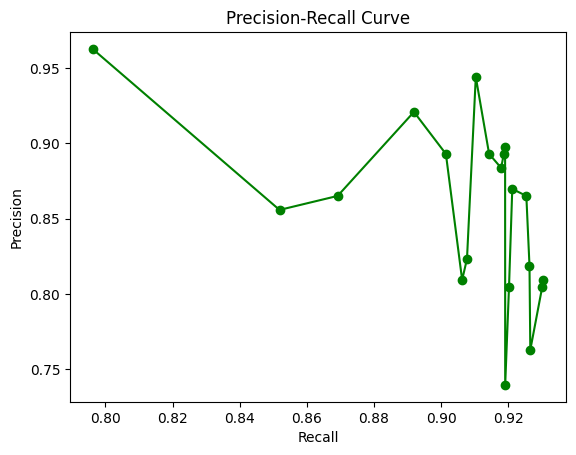

In [9]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Fine-tuning step 2
Using a 2-step fine-tuning, we are able to achieve much better performance.

In [10]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [11]:
model_name = "MixResNet_beefy"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 81.7%, Avg loss: 0.423975
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 82.7%, Avg loss: 0.728522


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 86.2%, Avg loss: 0.583359


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 80.3%, Avg loss: 1.115871


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 81.3%, Avg loss: 1.090958


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 84.4%, Avg loss: 0.473443


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 87.5%, Avg loss: 0.410019
New best model found! (based on lowest loss)
...and saved.


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 85.1%, Avg loss: 0.494763


Epoch 9/20
-------------------------------
Validation Error:
Accuracy: 86.2%, Avg loss: 0.

Test Error:
Accuracy: 91.0%, Avg loss: 0.341970
Confusion matrix report, tp: 192, fp: 14, fn: 12, tn:72
True


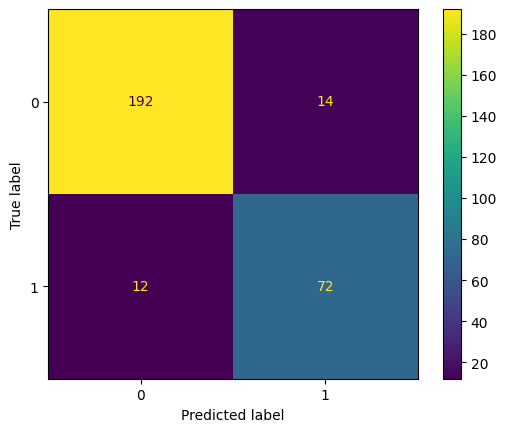

Precision: 0.93, Recall: 0.94, F1-Score: 0.94


(0.34196996688842773, tensor(0.9103, device='cuda:0'))

In [12]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

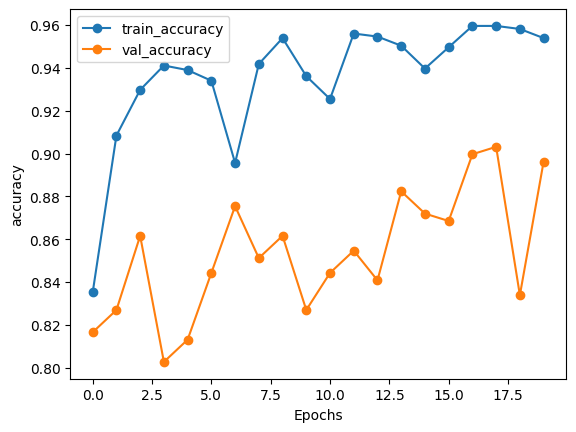

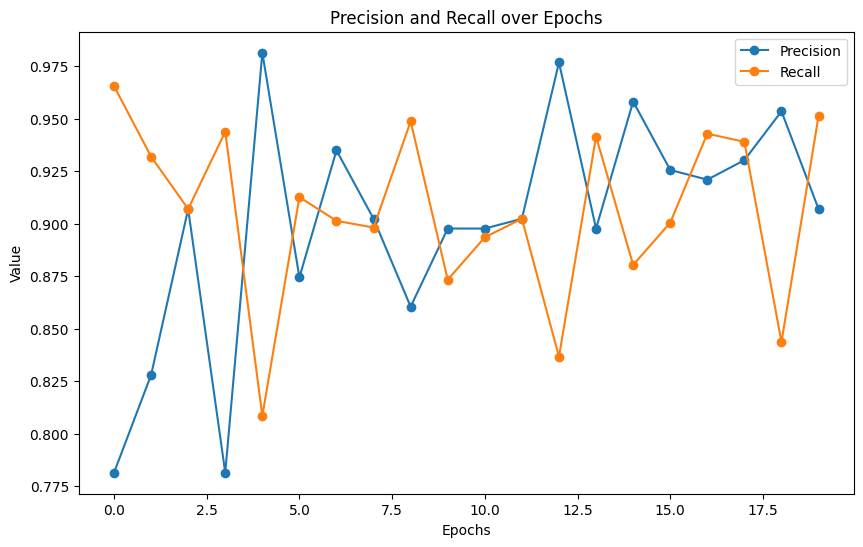

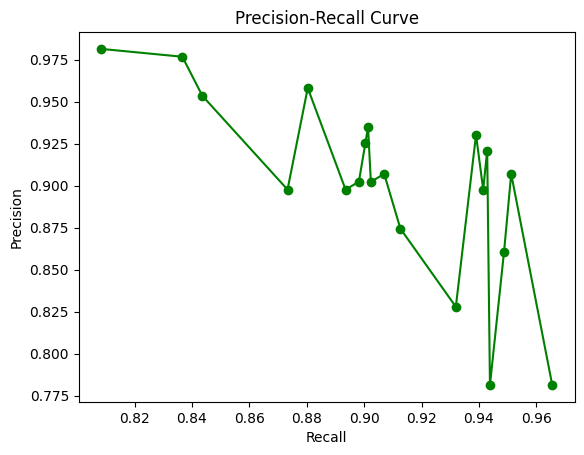

In [13]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

GradCAM + LIME quick test

In [14]:
target_layers = [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4]

100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


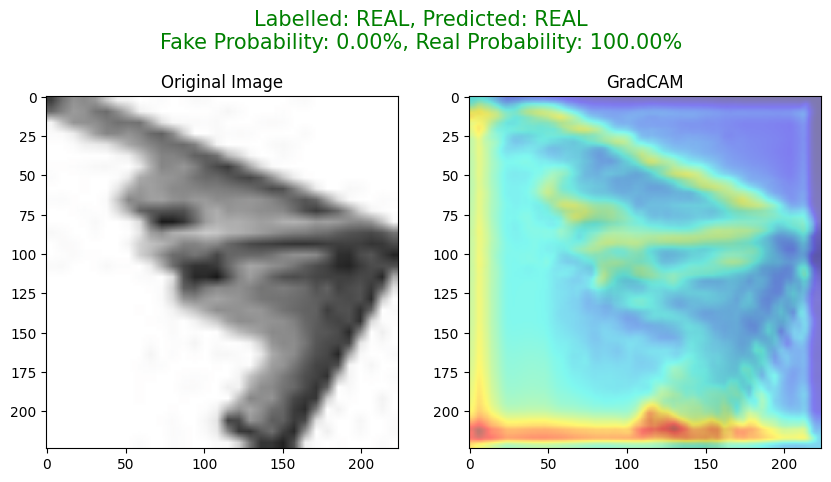

In [15]:
xai.explain_gradcam_single_image(train_dataloader,
                                ft_resnet50, target_layers, model_name = model_name,
                                dataset_name = DATASET_NAME,
                                index = 3)

100%|██████████| 1000/1000 [00:10<00:00, 99.00it/s]


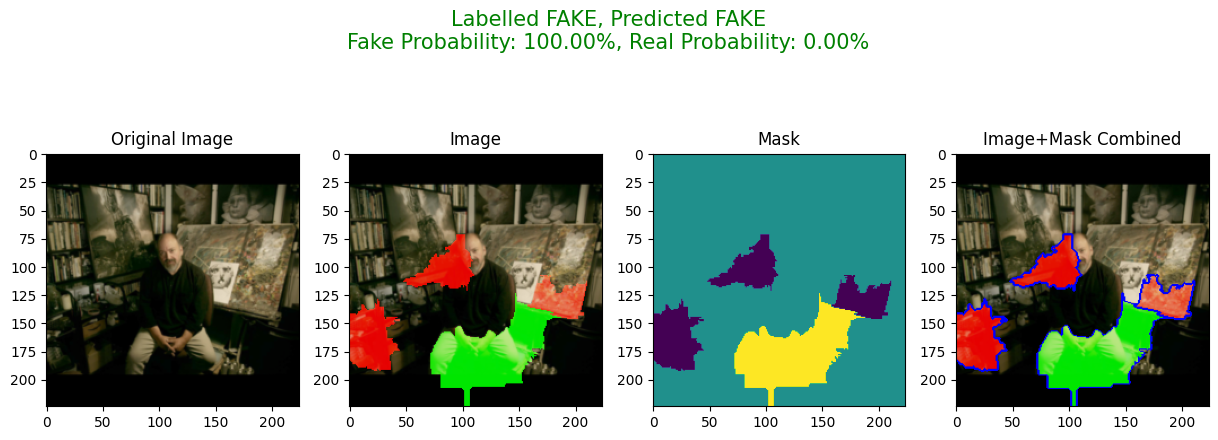

In [16]:
xai.explain_lime_single_image(train_dataloader, ft_resnet50)

### Batch visualization

  6%|▋         | 2/32 [00:02<00:32,  1.07s/it]


KeyboardInterrupt: 

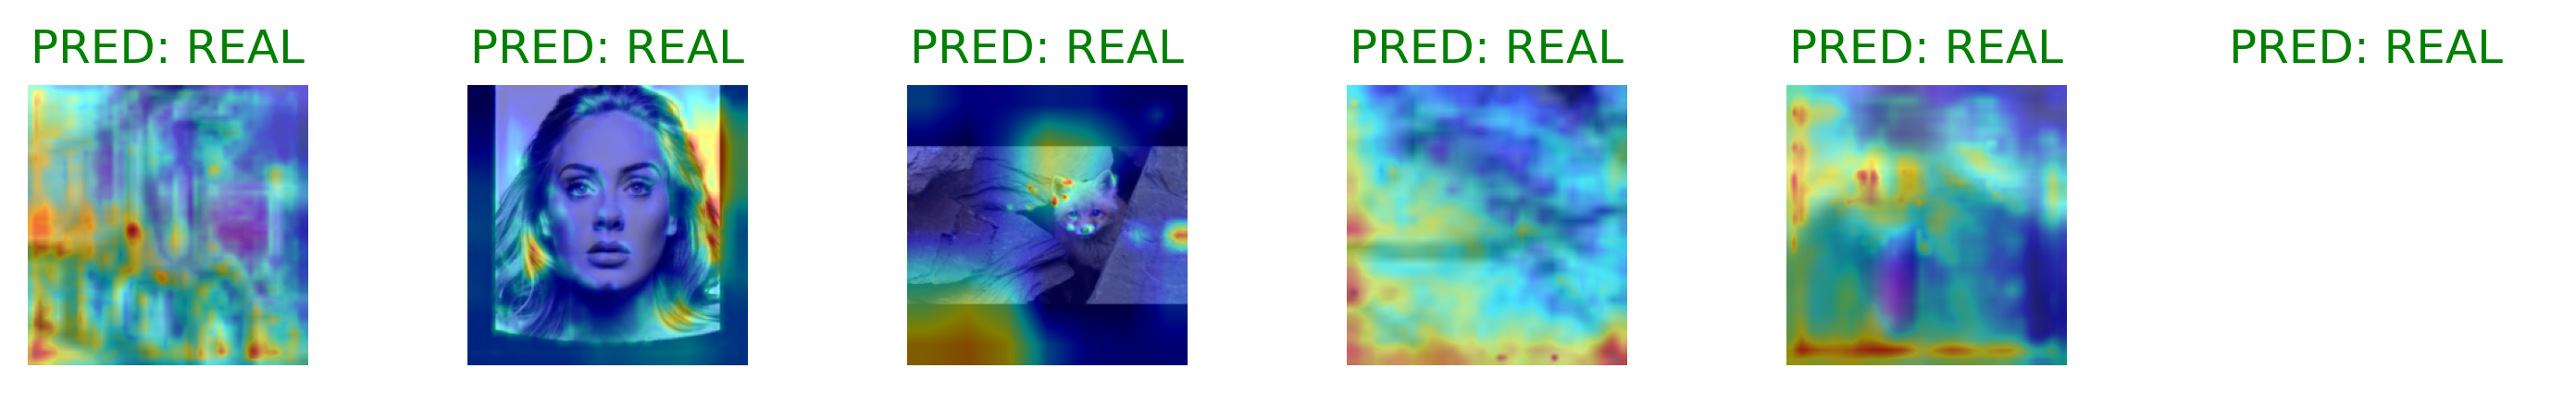

In [17]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, target_layers, model_name, DATASET_NAME)

In [ ]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Visualized batch #1!


## Data augmentation
Data augmentation process will first consist into taking a much smaller portion of the CIFAKE dataset.

In [6]:
import data_utils
# Load CIFAKE dataset and take a small subset
cifake_train = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
cifake_test = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)

# Take 0.8% of CIFAKE and split into train, val, and test
portion_size_train = int(0.0135 * len(cifake_train))
indices = torch.randperm(len(cifake_train))[:portion_size_train]
cifake_train = Subset(cifake_train, indices)

portion_size_test = int(0.0135 * len(cifake_test))
cifake_subset_test = Subset(cifake_test, list(range(portion_size_test)))

cifake_val, cifake_test = data_utils.train_test_split(
    split_ratio=(0.5),  # 85% train, 15% val
    dataset=cifake_subset_test,
    isRandom=True
)

print(len(cifake_train), len(cifake_test), len(cifake_val))

1350 135 135


#### Preparing the Augmented part of the dataset
As mentioned before, the RVAA is much underrepresented. As such, we need to apply the augmented transformations only on the RVAA dataset, while keeping only a fraction of the CIFAKE dataset.
In order to augment it, we simply apply:
- a random rotation
- a random horizontal flip (i.e. the image will be flipped with a 50/50 chance)

In previous attempts, we also tried to apply cropping. However, given that the dataset contains images which are put side by side with non-AI images, it can be destructive to the training process, as a random crop could contain a sample of a non-AI image. As such, we decided to avoid using it.

It is important to consider that only part of the RVAA dataset is used to create the augmented dataset.

In [7]:
augmented_transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 90 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

In [8]:
import copy
import random

# Create a deep copy of the dataset
original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)
# make a deepcopy to ensure it has the same order
rvaa_dataset_copy = copy.deepcopy(original_dataset)

# we are doing the same thing as the train_test_split function
train_size = int(0.8 * len(original_dataset))
val_size = int(0.10 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

generator = torch.Generator()
generator.manual_seed(seed)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(original_dataset)),
    [train_size, val_size, test_size],
    generator=generator
)

rvaa_train_dataset = Subset(original_dataset, train_indices)
rvaa_val_dataset = Subset(original_dataset, val_indices)
rvaa_test_dataset = Subset(original_dataset, test_indices)

augmented_size = int(0.8 * len(rvaa_train_dataset))
augmented_indices = random.sample(train_indices.indices, augmented_size)

rvaa_dataset_copy.transform = augmented_transform_rvaa
augmented_train_dataset = Subset(rvaa_dataset_copy, augmented_indices)

combined_train_dataset_rvaa = ConcatDataset([rvaa_train_dataset, augmented_train_dataset])

print(len(combined_train_dataset_rvaa), len(rvaa_test_dataset), len(rvaa_val_dataset))

1396 97 97


In [9]:
# Ensure augmented indices are within the training set
assert set(augmented_indices).issubset(train_indices), "Augmented indices include non-training data!"

# Ensure no overlap between validation and augmented data
assert not set(val_indices).intersection(augmented_indices), "Data leakage in validation set!"

# Ensure no overlap between test and augmented data
assert not set(test_indices).intersection(augmented_indices), "Data leakage in test set!"


In [10]:
train_dataset = ConcatDataset([cifake_train, combined_train_dataset_rvaa])
val_dataset = ConcatDataset([cifake_val, rvaa_val_dataset])
test_dataset = ConcatDataset([cifake_test, rvaa_test_dataset])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 2746
Validation dataset size: 232
Testing dataset size: 232


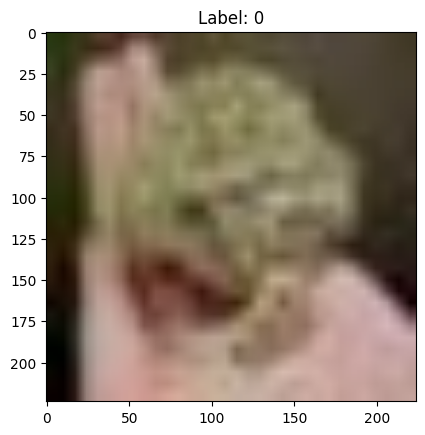

In [11]:
data_utils.show_random_sample(train_dataloader)

In [12]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
device = model_utils.get_device()
print(f"using {device} device")

model_utils.prepare_for_ft(ft_resnet50)
ft_resnet50.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

using cuda device


### Training Step1

In [13]:
model_name = "Augmented_MixResNet"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.633311, train accuracy: 61.05%  [ 2560/ 2746]
Validation Error:
Accuracy: 69.0%, Avg loss: 0.619796
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.542760, train accuracy: 70.82%  [ 2560/ 2746]
Validation Error:
Accuracy: 80.6%, Avg loss: 0.532412
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.578165, train accuracy: 72.11%  [ 2560/ 2746]
Validation Error:
Accuracy: 82.8%, Avg loss: 0.487959
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.498014, train accuracy: 74.41%  [ 2560/ 2746]
Validation Error:
Accuracy: 79.3%, Avg loss: 0.517735


Epoch 5/20
-------------------------------
Training loss: 0.549519, train accuracy: 74.34%  [ 2560/ 2746]
Validation Error:
Accuracy: 82.3%, Avg loss: 0.454184
New best model 

Test Error:
Accuracy: 78.0%, Avg loss: 0.445045
Confusion matrix report, tp: 134, fp: 44, fn: 7, tn:47
True


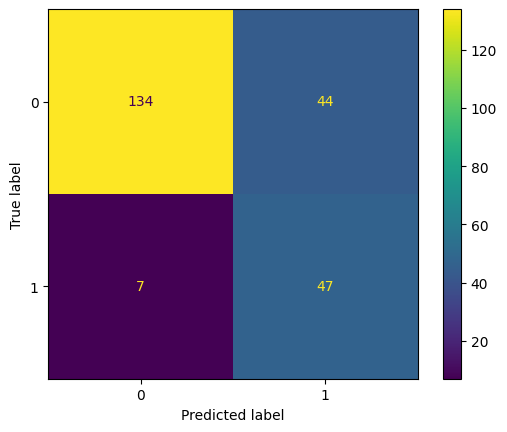

Precision: 0.75, Recall: 0.95, F1-Score: 0.84


(0.4450452849268913, tensor(0.7802, device='cuda:0'))

In [14]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

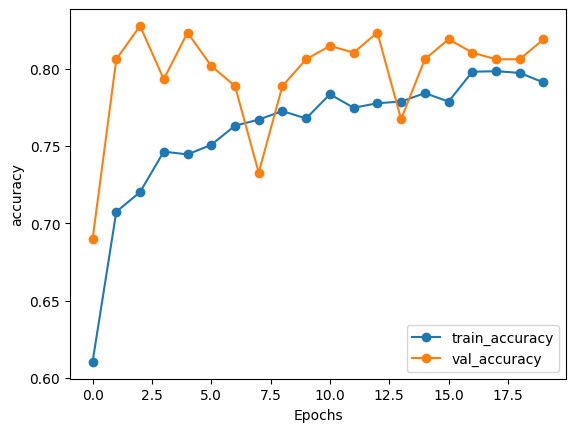

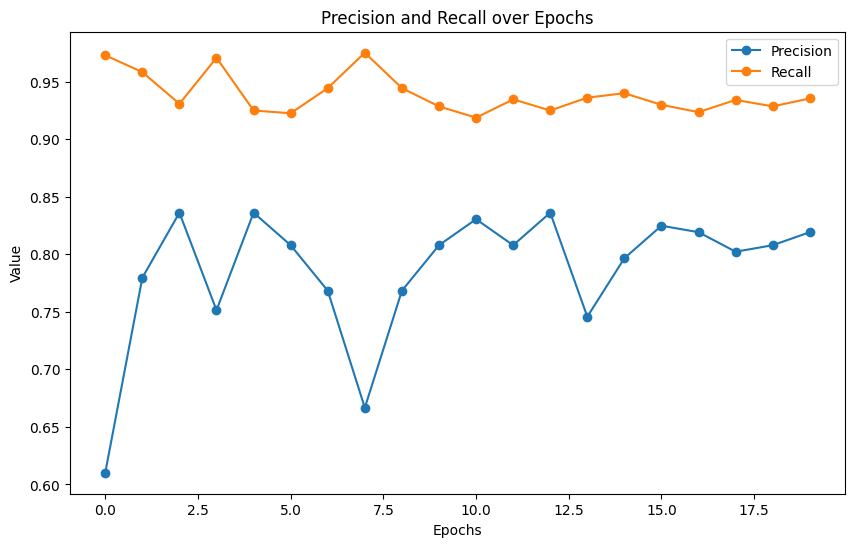

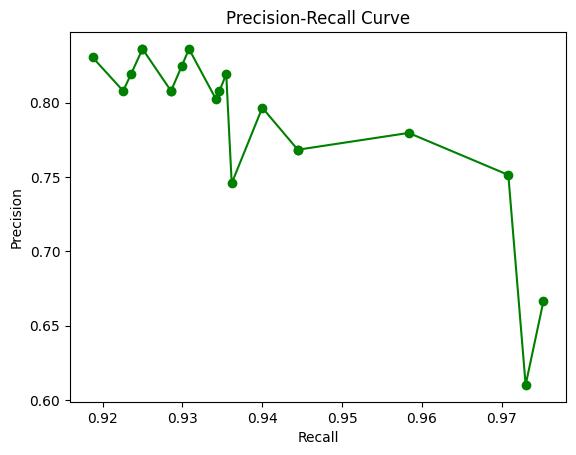

In [15]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Training Step2

In [16]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [17]:
model_name = "Augmented_MixResNet_beefy"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.505703, train accuracy: 79.80%  [ 2560/ 2746]
Validation Error:
Accuracy: 85.8%, Avg loss: 0.359493
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.149965, train accuracy: 89.84%  [ 2560/ 2746]
Validation Error:
Accuracy: 91.8%, Avg loss: 0.254179
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.161557, train accuracy: 91.76%  [ 2560/ 2746]
Validation Error:
Accuracy: 91.8%, Avg loss: 0.225785
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.240745, train accuracy: 95.00%  [ 2560/ 2746]
Validation Error:
Accuracy: 81.0%, Avg loss: 0.765518


Epoch 5/20
-------------------------------
Training loss: 0.084735, train accuracy: 95.59%  [ 2560/ 2746]
Validation Error:
Accuracy: 80.6%, Avg loss: 0.690626


Epoch 6/20
--

Test Error:
Accuracy: 91.8%, Avg loss: 0.273444
Confusion matrix report, tp: 172, fp: 6, fn: 13, tn:41
True


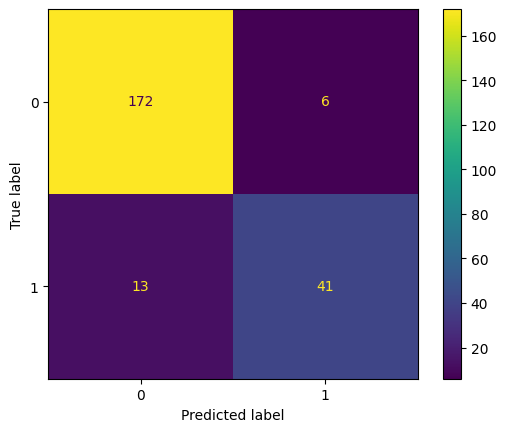

Precision: 0.97, Recall: 0.93, F1-Score: 0.95


(0.2734435489401221, tensor(0.9181, device='cuda:0'))

In [18]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

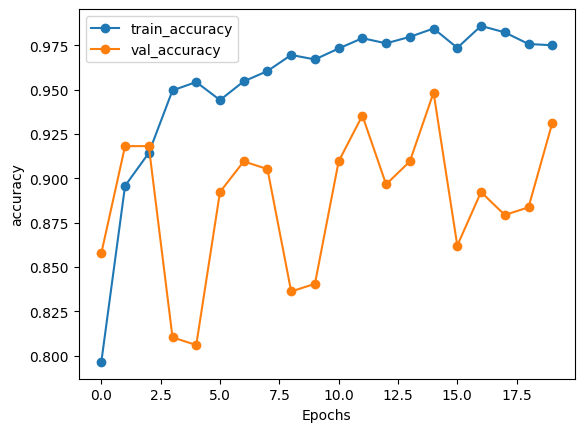

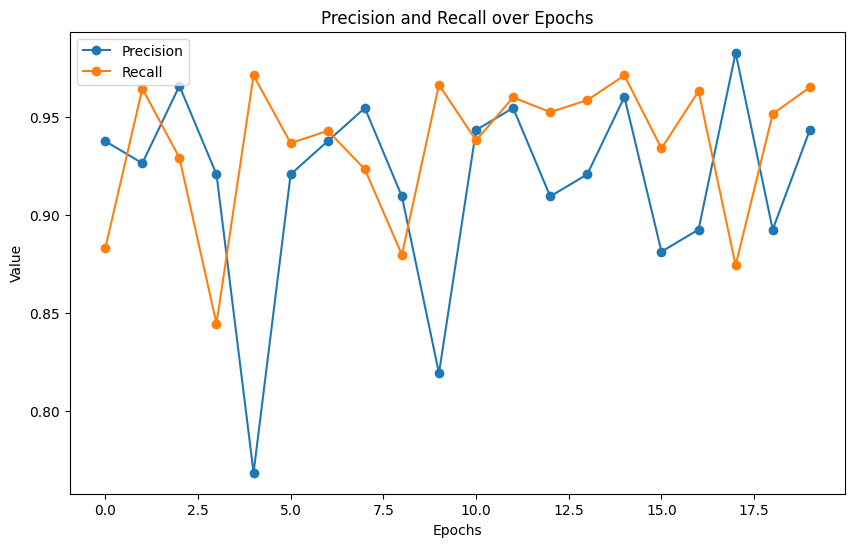

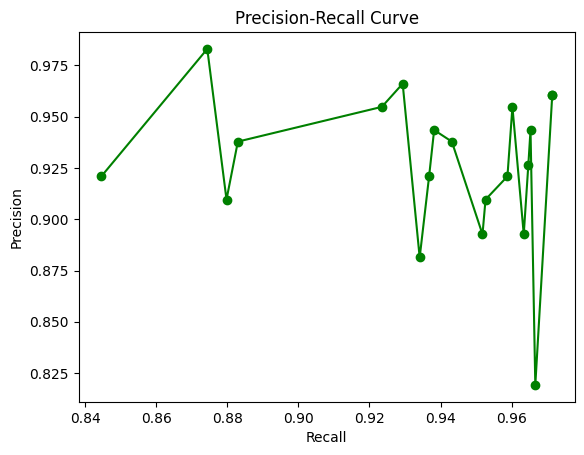

In [19]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### GradCam + LIME evaluation

100%|██████████| 64/64 [00:09<00:00,  6.89it/s]


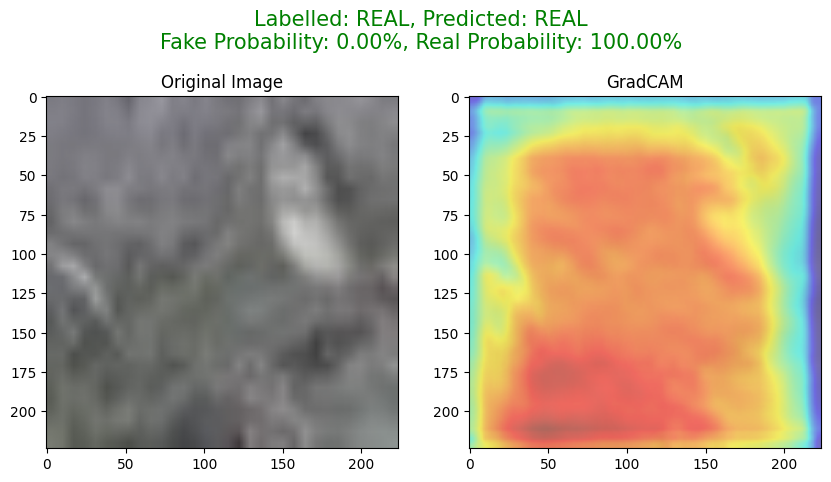

In [20]:
target_layers = [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4]
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, target_layers, model_name = model_name,
                                dataset_name = DATASET_NAME,
                                index = 3)

100%|██████████| 1000/1000 [00:05<00:00, 194.59it/s]


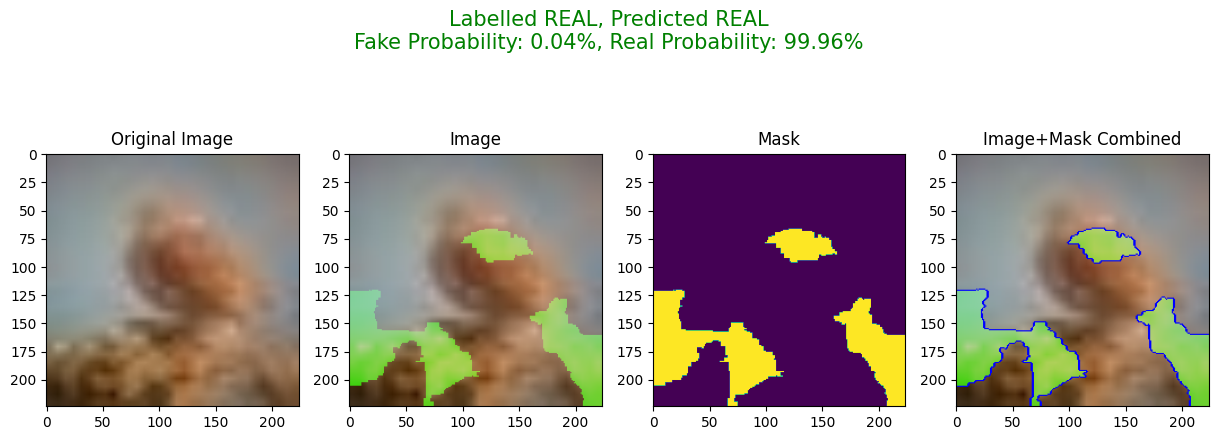

In [21]:
xai.explain_lime_single_image(test_dataloader, ft_resnet50,model_name = model_name,
                                dataset_name = DATASET_NAME)

### Batch visualization

In [22]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, target_layers, model_name, DATASET_NAME)

100%|██████████| 64/64 [00:32<00:00,  1.95it/s]


Visualized batch #1!


In [23]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                )

100%|██████████| 1000/1000 [00:03<00:00, 291.38it/s]


Visualized batch #1!
